<a href="https://colab.research.google.com/github/Jingqi-Wang0416/MUSA-6950-Final-Project/blob/main/Final_Project_Jingqi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies (if needed)
!pip install py3dep rioxarray geopandas rasterstats

from shapely.geometry import box
import geopandas as gpd
import py3dep

# Define larger bounding box to cover all streets (adjust if needed)
bbox = box(-80.45, 25.55, -79.95, 26.00)
gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Download DEM using py3dep (30m resolution)
dem = py3dep.get_dem(gdf.geometry[0], resolution=30, crs="EPSG:4326")

# Save to GeoTIFF
dem.rio.to_raster("miami_dem_expanded.tif")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.5/289.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.6 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np

# Read DEM
with rasterio.open("miami_dem_expanded.tif") as src:
    dem = src.read(1)
    transform = src.transform
    profile = src.profile

# Calculate cell size
xres = transform[0]
yres = -transform[4]

# Compute slope in degrees
dy, dx = np.gradient(dem, yres, xres)
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

# Save slope raster
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open("miami_slope_expanded.tif", "w", **profile) as dst:
    dst.write(slope_deg.astype(rasterio.float32), 1)


In [ ]:
import rioxarray

# Reproject slope to Web Mercator
slope = rioxarray.open_rasterio("miami_slope_expanded.tif", masked=True)
slope_proj = slope.rio.reproject("EPSG:3857")
slope_proj.rio.to_raster("miami_slope_proj.tif")


In [ ]:
import geopandas as gpd
import numpy as np
import rioxarray
from rasterstats import zonal_stats

# Read in slope raster and reproject to Web Mercator
slope = rioxarray.open_rasterio("miami_slope_expanded.tif", masked=True)
slope_proj = slope.rio.reproject("EPSG:3857")
slope_proj.rio.to_raster("miami_slope_proj.tif")

# Load street data and reproject to match slope raster
streets = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Streets.geojson")
streets = streets.to_crs("EPSG:3857")

# Compute average slope for each street segment using zonal statistics
stats = zonal_stats(
    vectors=streets["geometry"],
    raster="miami_slope_proj.tif",
    stats=["mean"],
    geojson_out=True
)

# Convert to GeoDataFrame and clean up
streets_slope = gpd.GeoDataFrame.from_features(stats)
streets_slope.rename(columns={"mean": "mean_slope"}, inplace=True)
streets_slope = streets_slope.set_crs("EPSG:3857")

# Filter steep streets
steep_streets = streets_slope[streets_slope["mean_slope"] > 3]

# Export for reuse
streets_slope.to_file("/content/drive/MyDrive/Colab Notebooks/Miami/streets_with_slope.geojson", driver="GeoJSON")
steep_streets.to_file("/content/drive/MyDrive/Colab Notebooks/Miami/steep_streets.geojson", driver="GeoJSON")


In [ ]:
import geopandas as gpd
import pandas as pd

# Load landmarks and steep streets
landmarks = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Landmarks.geojson").to_crs("EPSG:3857")
steep_streets = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/steep_streets.geojson").to_crs("EPSG:3857")

# Create 300m buffer around landmarks
landmarks["buffer_300m"] = landmarks.buffer(300)

# Convert buffer column into new GeoDataFrame for spatial join
landmark_buffers = landmarks.copy()
landmark_buffers.set_geometry("buffer_300m", inplace=True)

# Perform spatial join
joined = gpd.sjoin(landmark_buffers, steep_streets, how="left", predicate="intersects")

# Check actual FID column name after join
fid_col = "FID_left" if "FID_left" in joined.columns else "FID"

# Count steep streets near each landmark
steep_count = joined.groupby(fid_col).size().reset_index(name="steep_streets_within_300m")

# Merge back to original landmarks
landmarks["FID"] = landmarks["FID"].astype(int)
steep_count[fid_col] = steep_count[fid_col].astype(int)
landmarks = landmarks.merge(steep_count, left_on="FID", right_on=fid_col, how="left")
landmarks["steep_streets_within_300m"] = landmarks["steep_streets_within_300m"].fillna(0).astype(int)

# Merge landmark names
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Miami/Landmarks.csv")
landmarks = landmarks.merge(df[["FID", "LMNAME", "LMCNAME"]], on="FID", how="left")

# Display top 20
top_landmarks = landmarks.sort_values(by="steep_streets_within_300m", ascending=False)[
    ["LMNAME_y", "LMCNAME_y", "steep_streets_within_300m"]
].head(20).reset_index(drop=True)
top_landmarks.columns = ["Landmark Name", "Category", "Steep Streets Within 300m"]

top_landmarks


,Landmark Name,Category,Steep Streets Within 300m
0,MIAMI METER COMPANY,Business,16
1,364X,Ramp,11
2,MIAMI-DADE WATER DEP,Other,9
3,450X,Ramp,8
4,LITTLE RIVER ELEM,School,7
5,150X,Ramp,6
6,485X,Ramp,5
7,355X,Ramp,5
8,FIRE STATION 6,Fire Station,4
9,167X,Ramp,4


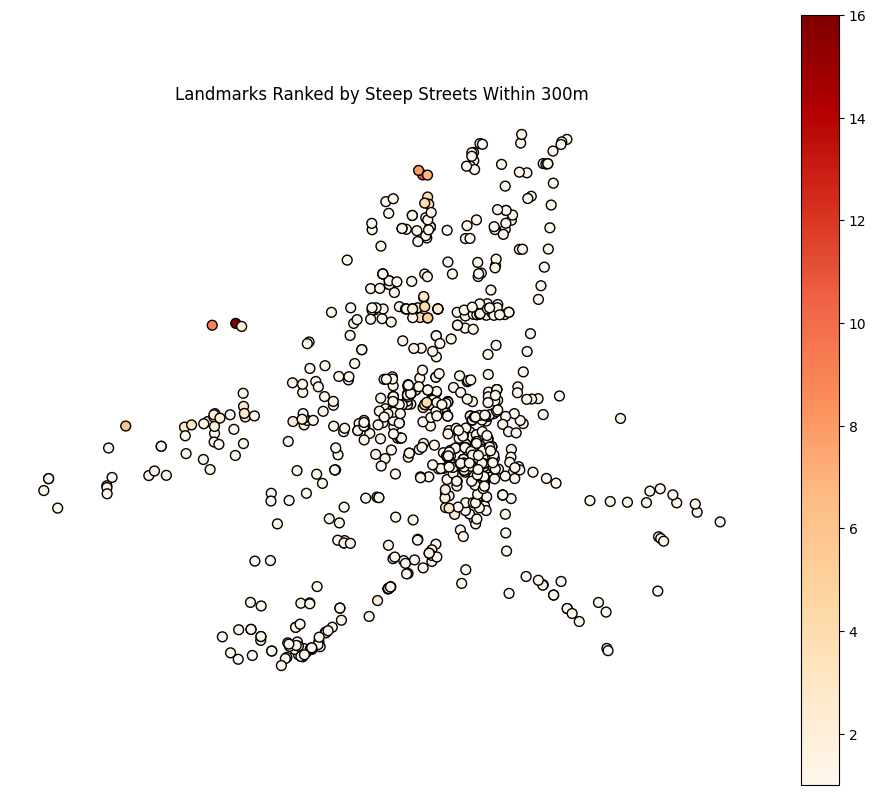

In [ ]:
import matplotlib.pyplot as plt

# Plot landmark heatmap using steep streets within 300m buffer
fig, ax = plt.subplots(figsize=(12, 10))
landmarks.plot(
    ax=ax,
    column="steep_streets_within_300m",
    cmap="OrRd",
    legend=True,
    markersize=50,
    edgecolor="black"
)

plt.title("Landmarks Ranked by Steep Streets Within 300m")
plt.axis("off")
plt.show()


In [ ]:
import geopandas as gpd

# Load trolley routes and landmarks
trolley = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Trolley_Routes.geojson")
landmarks = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Landmarks.geojson")

# Ensure both have the same CRS (project to metric if needed)
trolley = trolley.to_crs(epsg=3857)
landmarks = landmarks.to_crs(trolley.crs)


In [ ]:
# Create 300-meter buffer around trolley lines
trolley_buffer = trolley.copy()
trolley_buffer["geometry"] = trolley_buffer.buffer(300)


In [ ]:
# Spatial join (preserve geometry for mapping)
landmarks_covered = gpd.sjoin(landmarks, trolley_buffer, how="inner", predicate="intersects")

# Keep geometry + useful attributes
landmarks_covered = landmarks_covered[["geometry", "LMNAME", "LMCNAME"]].drop_duplicates().reset_index(drop=True)
landmarks_covered.columns = ["geometry", "Landmark Name", "Category"]

# Convert back to GeoDataFrame (if needed)
landmarks_covered = gpd.GeoDataFrame(landmarks_covered, geometry="geometry", crs=landmarks.crs)

# Preview
landmarks_covered.head(20)



,geometry,Landmark Name,Category
0,POINT (-8927901.007 2970208.904),MIAMI PRKG LOT 29,Parking Garage/Lot
1,POINT (-8929991.039 2970100.879),MIAMI PRKG LOT 35,Parking Garage/Lot
2,POINT (-8927337.579 2971136.938),DADE FEDERAL BLDG,Court House
3,POINT (-8932455.736 2965442.431),SENOR FROGS REST,Restaurant
4,POINT (-8926729.364 2971120.521),ARGENTINA CONSULATE,Consulate/Embassy
5,POINT (-8926729.364 2971120.521),BAHAMAS CONSULATE,Consulate/Embassy
6,POINT (-8926729.364 2971120.521),BOLIVIA CONSULATE,Consulate/Embassy
7,POINT (-8936572.822 2971652.289),ANTONIO MACEO PARK,Park
8,POINT (-8933216.3 2970218.221),AUBURNDALE ELEM,School
9,POINT (-8926469.796 2971277.118),BRAZIL CONSULATE,Consulate/Embassy


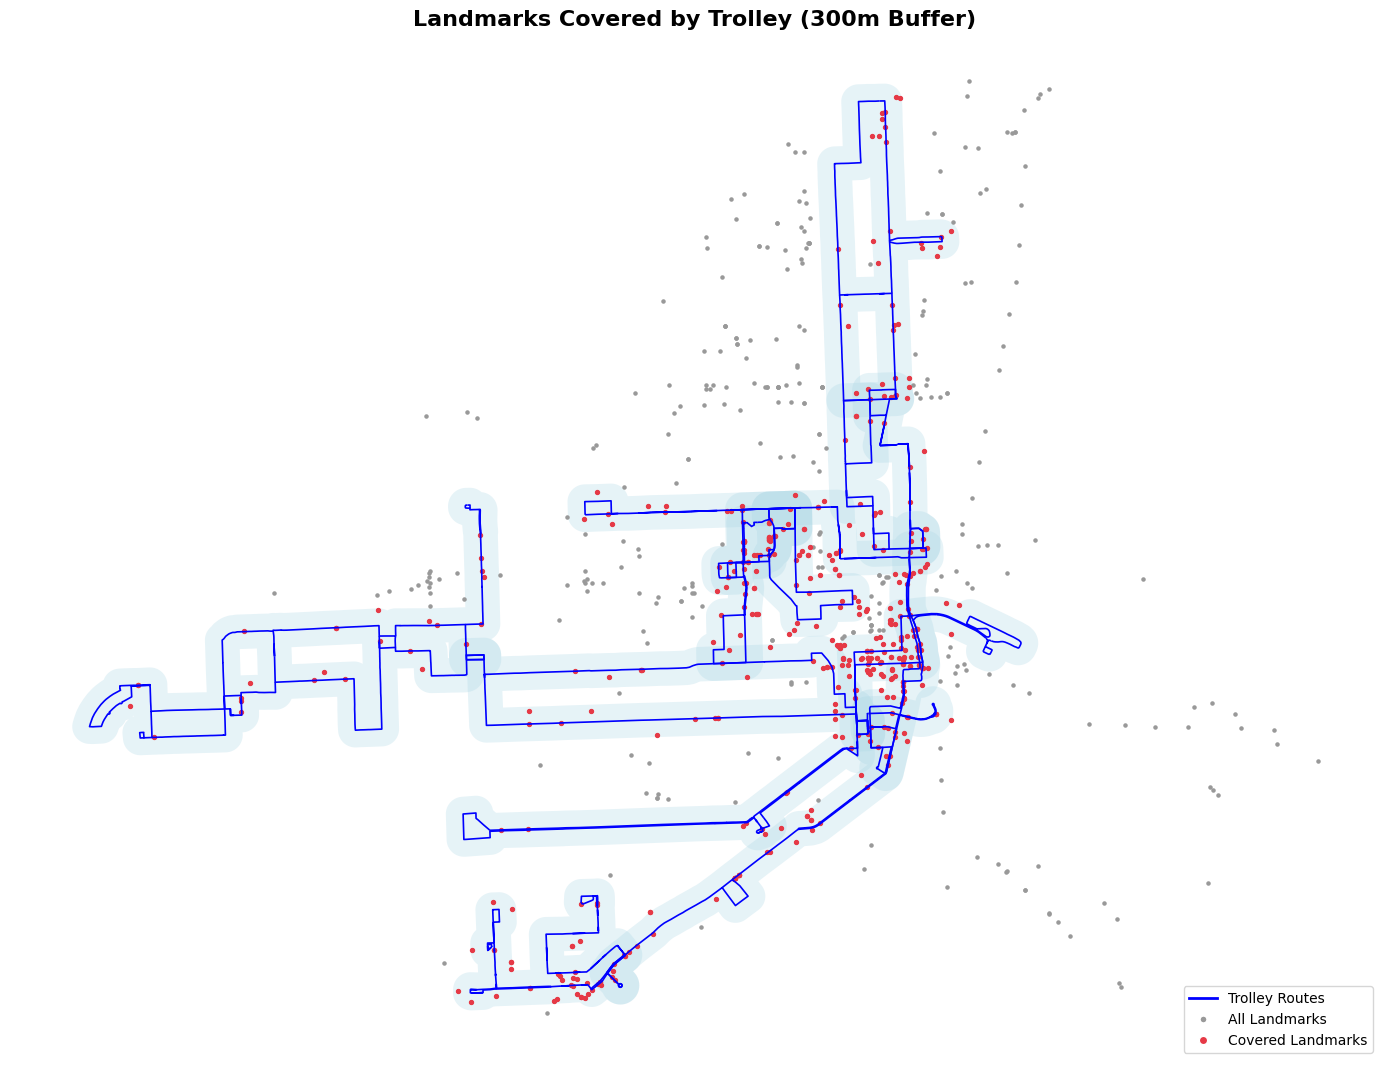

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(14, 14))

# Buffer layer (lowest layer)
trolley_buffer.plot(ax=ax, color="lightblue", alpha=0.3, zorder=0)

# All landmarks (gray, small)
landmarks.plot(ax=ax, color="#999999", markersize=5, zorder=1)

# Covered landmarks (red, small)
landmarks_covered.plot(ax=ax, color="#e63946", markersize=8, zorder=2)

# Trolley routes (on top of points!)
trolley.plot(ax=ax, color="blue", linewidth=1.2, zorder=3)

# Title
plt.title("Landmarks Covered by Trolley (300m Buffer)", fontsize=16, fontweight="bold")

# Custom legend
legend_elements = [
    Line2D([0], [0], color="blue", lw=2, label="Trolley Routes"),
    Line2D([0], [0], marker='o', color='w', label="All Landmarks", markerfacecolor='#999999', markersize=5),
    Line2D([0], [0], marker='o', color='w', label="Covered Landmarks", markerfacecolor='#e63946', markersize=6),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10, frameon=True)

# Clean up
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# Identify uncovered landmarks using index exclusion
covered_idx = landmarks_covered.index
uncovered_landmarks = landmarks[~landmarks.index.isin(covered_idx)].copy()

# Print statistics
print(f"Total landmarks: {len(landmarks)}")
print(f"Covered landmarks: {len(landmarks_covered)}")
print(f"Uncovered landmarks: {len(uncovered_landmarks)}")

# Save uncovered landmarks to file
uncovered_landmarks.to_file("/content/drive/MyDrive/Colab Notebooks/Miami/uncovered_landmarks.geojson", driver="GeoJSON")


Total landmarks: 765
Covered landmarks: 469
Uncovered landmarks: 296


In [ ]:
from shapely.strtree import STRtree

# Build spatial index from trolley route geometries
trolley_geoms = list(trolley.geometry)
trolley_tree = STRtree(trolley_geoms)

# Safely compute nearest distance from each landmark to trolley routes
landmarks["min_dist_to_trolley"] = landmarks.geometry.apply(
    lambda point: min(point.distance(line) for line in trolley_geoms)
)


# Sort landmarks by distance
landmarks_sorted_by_dist = landmarks.sort_values("min_dist_to_trolley", ascending=False)

# Preview most and least accessible landmarks
print("Top 10 farthest landmarks:")
print(landmarks_sorted_by_dist[["LMNAME", "LMCNAME", "min_dist_to_trolley"]].head(10))

print("\nTop 10 closest landmarks:")
print(landmarks_sorted_by_dist[["LMNAME", "LMCNAME", "min_dist_to_trolley"]].tail(10))


Top 10 farthest landmarks:
                   LMNAME            LMCNAME  min_dist_to_trolley
263    Gov. Cut Marker 11  Aid to Navigation          5544.124310
515    SUNDAYS ON THE BAY         Restaurant          5518.054788
61        BEAR CUT BRIDGE             Bridge          5444.675520
163    Virginia Key Beach              Beach          5240.559097
264    Gov. Cut Marker 13  Aid to Navigation          4782.789365
187        VIRGINIA BEACH              Beach          4754.813180
265    Gov. Cut Marker 12  Aid to Navigation          4643.542051
291  DADE MARINE INSTITUT             School          4384.019899
272          Norris Cut E  Aid to Navigation          4308.507814
85            HOBIE BEACH              Beach          4269.535134

Top 10 closest landmarks:
                   LMNAME          LMCNAME  min_dist_to_trolley
26        BRICKELL BRIDGE           Bridge             0.566775
692        MIRACLE CENTER  Shopping Center             0.442436
391        FIRE STATION 5   

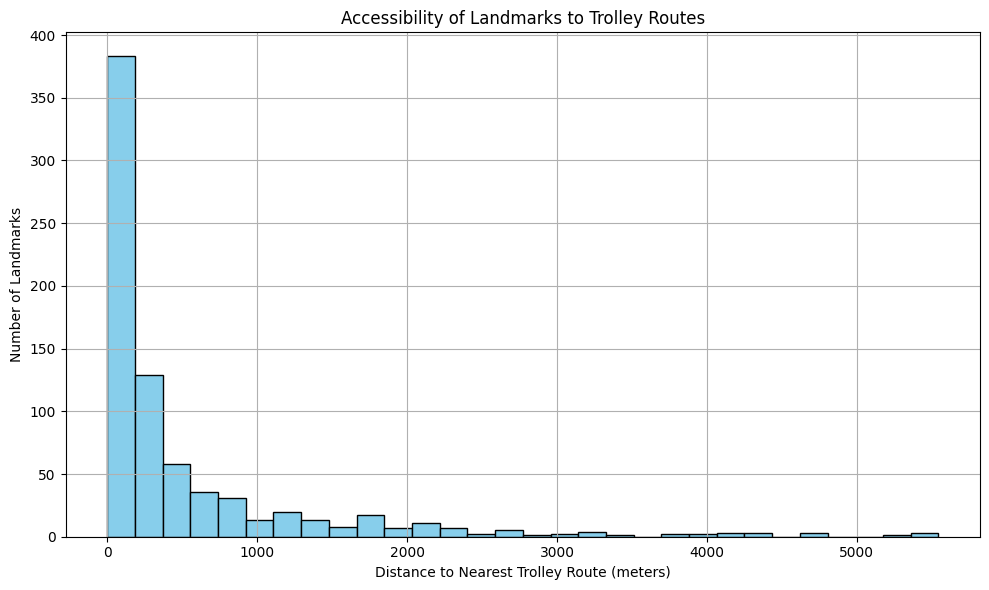

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
landmarks["min_dist_to_trolley"].hist(bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Distance to Nearest Trolley Route (meters)")
plt.ylabel("Number of Landmarks")
plt.title("Accessibility of Landmarks to Trolley Routes")
plt.grid(True)
plt.tight_layout()
plt.show()


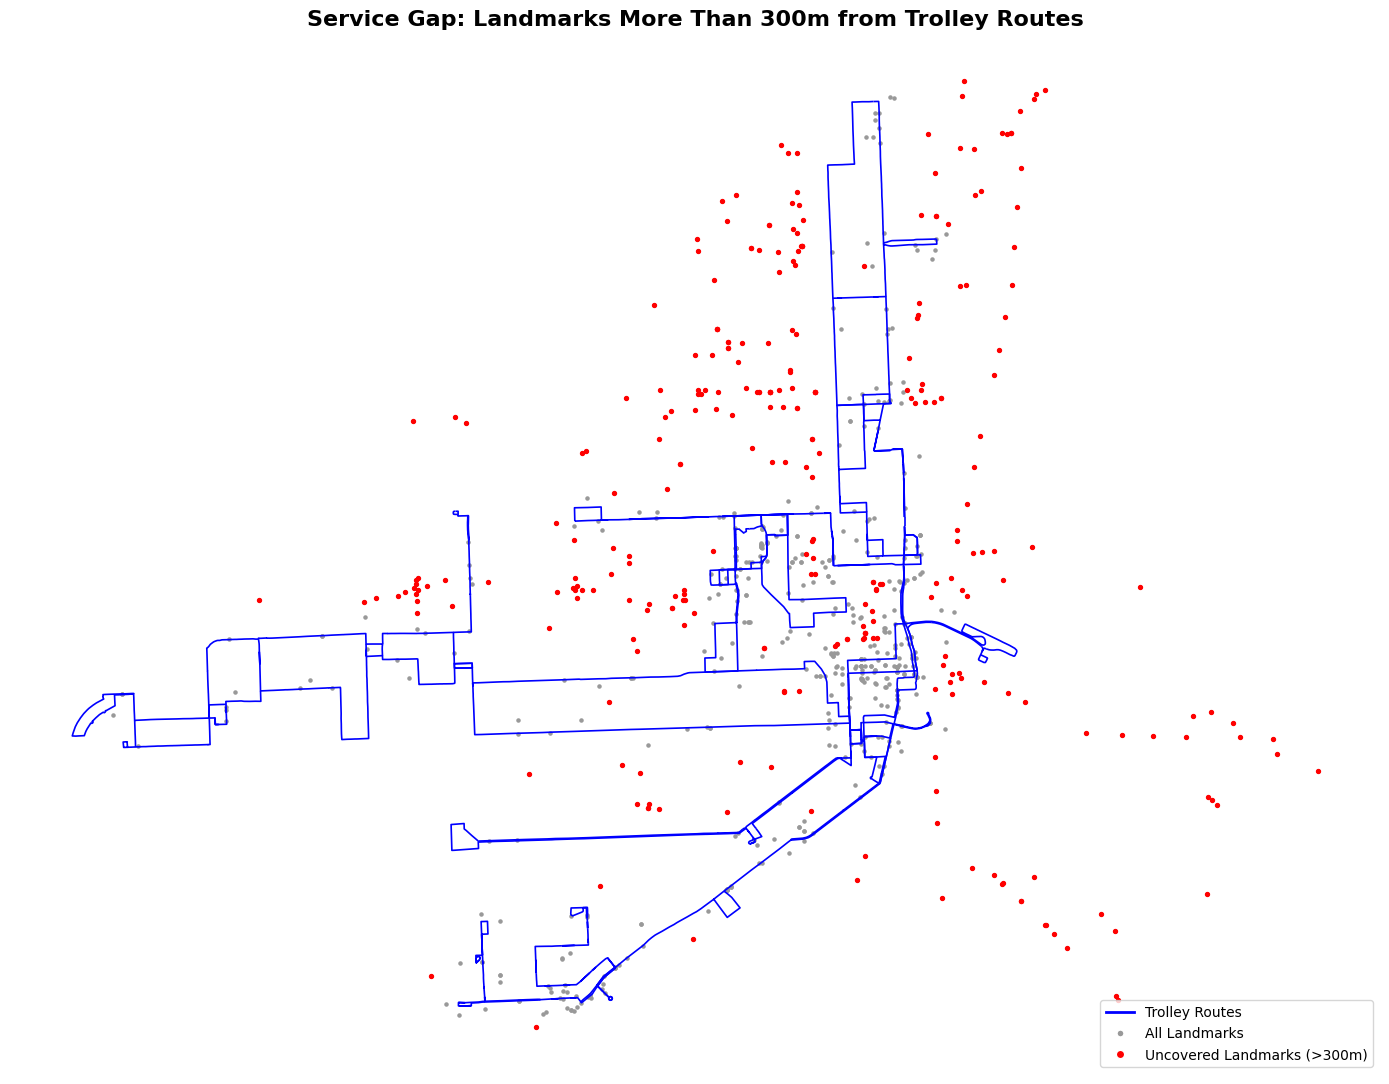

In [ ]:
# Filter landmarks more than 300 meters from trolley
far_landmarks = landmarks[landmarks["min_dist_to_trolley"] > 300]

# Plot map
fig, ax = plt.subplots(figsize=(14, 14))

# All landmarks
landmarks.plot(ax=ax, color="#999999", markersize=5, zorder=1)

# Far landmarks (service gap)
far_landmarks.plot(ax=ax, color="red", markersize=8, zorder=2)

# Trolley routes
trolley.plot(ax=ax, color="blue", linewidth=1.2, zorder=3)

# Title
plt.title("Service Gap: Landmarks More Than 300m from Trolley Routes", fontsize=16, fontweight="bold")

# Custom legend
legend_elements = [
    Line2D([0], [0], color="blue", lw=2, label="Trolley Routes"),
    Line2D([0], [0], marker='o', color='w', label="All Landmarks", markerfacecolor='#999999', markersize=5),
    Line2D([0], [0], marker='o', color='w', label="Uncovered Landmarks (>300m)", markerfacecolor='red', markersize=6),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10, frameon=True)

# Remove axes
ax.set_axis_off()
plt.tight_layout()
plt.show()


<ipython-input-22-95b307c4f644>:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = trolley_buffer.unary_union


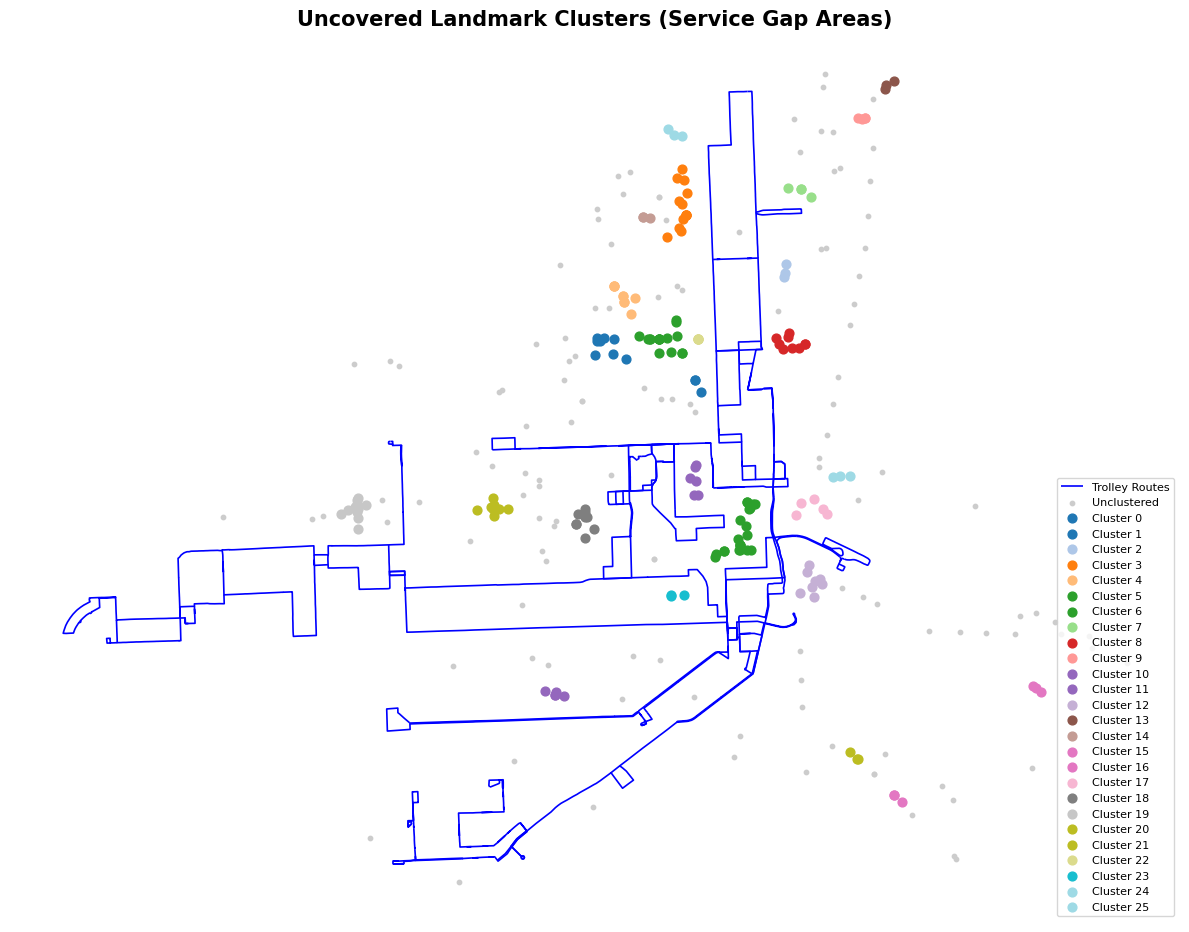

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN

# Ensure CRS match
trolley_buffer = trolley_buffer.to_crs(landmarks.crs)
trolley = trolley.to_crs(landmarks.crs)

# More precise buffer containment check
buffer_union = trolley_buffer.unary_union
landmarks["covered"] = landmarks.geometry.apply(lambda x: buffer_union.contains(x))

# Filter uncovered landmarks
uncovered = landmarks[~landmarks["covered"]].copy()

# Convert to centroid (in case geometry is not point)
uncovered["geometry"] = uncovered.geometry.centroid

# Cluster using DBSCAN
coords = np.array(list(zip(uncovered.geometry.x, uncovered.geometry.y)))
db = DBSCAN(eps=300, min_samples=3).fit(coords)
uncovered["cluster"] = db.labels_

# Plot result
fig, ax = plt.subplots(figsize=(12, 12))

# Plot trolley routes
trolley.plot(ax=ax, color="blue", linewidth=1.2, label="Trolley Routes", zorder=0)

# Plot unclustered uncovered landmarks (noise)
uncovered[uncovered["cluster"] == -1].plot(ax=ax, color="#cccccc", markersize=10, label="Unclustered", zorder=1)

# Plot clustered landmarks
cluster_ids = sorted([c for c in uncovered["cluster"].unique() if c != -1])
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_ids)))

for i, cluster_id in enumerate(cluster_ids):
    group = uncovered[uncovered["cluster"] == cluster_id]
    group.plot(ax=ax, color=colors[i], markersize=40, label=f"Cluster {cluster_id}", zorder=2)

# Final formatting
plt.title("Uncovered Landmark Clusters (Service Gap Areas)", fontsize=15, fontweight="bold")
plt.legend(loc="lower right", fontsize=8)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
cluster_summary = uncovered[uncovered["cluster"] != -1].groupby("cluster").agg(
    count=("LMNAME", "count"),
    mean_distance=("min_dist_to_trolley", "mean")
).reset_index().sort_values("count", ascending=False)

cluster_summary


,cluster,count,mean_distance
6,6,21,374.281260
5,5,16,1053.587792
3,3,14,579.543435
19,19,11,711.841324
8,8,9,580.875198
4,4,9,1840.583507
18,18,9,574.644779
12,12,8,459.784380
20,20,8,1171.629754
0,0,8,2004.532014


In [ ]:
# Display landmark names and distances for each cluster
clustered_landmarks = uncovered[uncovered["cluster"] != -1][
    ["cluster", "LMNAME", "LMCNAME", "min_dist_to_trolley"]
].sort_values(by=["cluster", "min_dist_to_trolley"])

# Show top 30 entries (you can scroll)
clustered_landmarks.head(30)


,cluster,LMNAME,LMCNAME,min_dist_to_trolley
470,0,ALLAPATTAH MR STA,MetroRail Station,1730.051939
497,0,NEW HORIZONS,Rehabilitation Center,1836.298491
1,0,INTERNAL AFFAIRS-IA,Police Facility,1842.245480
309,0,135X,Ramp,2035.962563
52,0,134X,Ramp,2112.849793
311,0,133X,Ramp,2114.588328
600,0,252X,Ramp,2180.451042
602,0,251X,Ramp,2183.808475
650,1,ENEIDA HARTNER ELEM,School,337.757500
2,1,ROBERT E LEE JR HIGH,School,442.946601


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Ensure CRS match before clustering
trolley_buffer = trolley_buffer.to_crs(landmarks.crs)
trolley = trolley.to_crs(landmarks.crs)

# Use unary_union to define full buffer area
buffer_union = trolley_buffer.unary_union
landmarks["covered"] = landmarks.geometry.apply(lambda x: buffer_union.contains(x))

# Extract uncovered landmarks
uncovered = landmarks[~landmarks["covered"]].copy()

# Ensure point geometry (for clustering)
uncovered["geometry"] = uncovered.geometry.centroid

# Apply DBSCAN clustering
coords = np.array(list(zip(uncovered.geometry.x, uncovered.geometry.y)))
db = DBSCAN(eps=300, min_samples=3).fit(coords)
uncovered["cluster"] = db.labels_

# Save copy for further analysis
uncovered_clusters = uncovered.copy()


<ipython-input-25-3881c1402064>:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = trolley_buffer.unary_union


In [ ]:
from shapely.geometry import Point

# Collect cluster IDs
cluster_ids = [c for c in uncovered_clusters["cluster"].unique() if c != -1]

centroids = []

# Compute centroids by selecting the nearest point to cluster center
for cluster_id in cluster_ids:
    group = uncovered_clusters[uncovered_clusters["cluster"] == cluster_id].copy()
    cluster_center = group.unary_union.centroid
    group["dist"] = group.geometry.distance(cluster_center)
    closest_point = group.loc[group["dist"].idxmin()]
    centroids.append({
        "cluster": cluster_id,
        "geometry": closest_point.geometry
    })

cluster_centroids = gpd.GeoDataFrame(centroids, geometry="geometry", crs=uncovered_clusters.crs)


<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_center = group.unary_union.centroid
<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_center = group.unary_union.centroid
<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_center = group.unary_union.centroid
<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_center = group.unary_union.centroid
<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_center = group.unary_union.centroid
<ipython-input-26-70d76a569ea9>:11: DeprecationWarning: The 'unary_union' attribute i

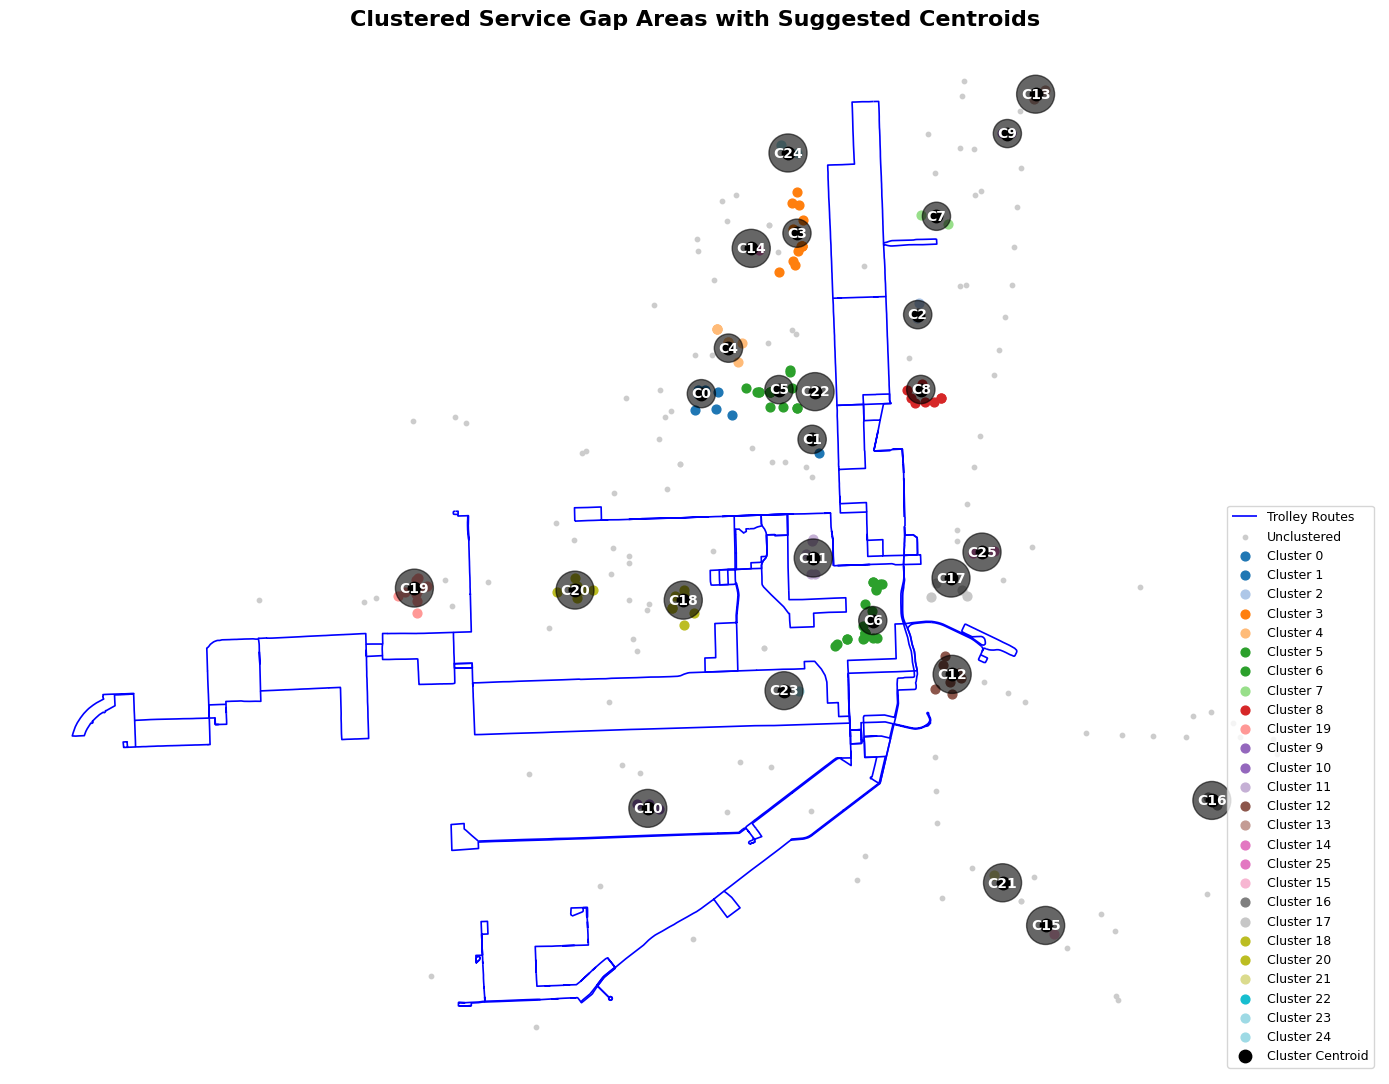

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 14))

# Plot trolley routes
trolley.plot(ax=ax, color="blue", linewidth=1.2, zorder=0, label="Trolley Routes")

# Plot unclustered points
uncovered_clusters[uncovered_clusters["cluster"] == -1].plot(
    ax=ax, color="#cccccc", markersize=10, zorder=1, label="Unclustered"
)

# Plot clustered points with color
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_ids)))
for i, cluster_id in enumerate(cluster_ids):
    group = uncovered_clusters[uncovered_clusters["cluster"] == cluster_id]
    group.plot(ax=ax, color=colors[i], markersize=40, label=f"Cluster {cluster_id}", zorder=2)

# Plot centroid points
cluster_centroids.plot(ax=ax, color="black", markersize=80, zorder=3, label="Cluster Centroid")

# Label each centroid
for idx, row in cluster_centroids.iterrows():
    ax.text(row.geometry.x, row.geometry.y, f"C{row['cluster']}", fontsize=10, fontweight="bold",
            ha="center", va="center", color="white", zorder=4,
            bbox=dict(facecolor='black', alpha=0.6, boxstyle='circle'))

# Layout
plt.title("Clustered Service Gap Areas with Suggested Centroids", fontsize=16, fontweight="bold")
plt.legend(loc="lower right", fontsize=9)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# Define the categories of interest
categories_of_interest = [
    "Beach", "Mall", "Museum", "Park", "Hotel",
    "Shopping center", "Theater/Performing Arts", "Tourist Attraction"
]

# Extract relevant data
clustered_landmarks = uncovered[uncovered["cluster"] != -1][
    ["cluster", "LMNAME", "LMCNAME", "min_dist_to_trolley"]
]

# Filter only those categories
focused_landmarks = clustered_landmarks[clustered_landmarks["LMCNAME"].isin(categories_of_interest)]

# Group and summarize
focused_summary = focused_landmarks.groupby(["cluster", "LMCNAME"]).agg(
    count=("LMNAME", "count"),
    avg_distance=("min_dist_to_trolley", "mean")
).reset_index().sort_values(["cluster", "count"], ascending=[True, False])

# Show summary
focused_summary


,cluster,LMCNAME,count,avg_distance
0,3,Park,3,500.217410
1,4,Park,6,1850.422165
2,5,Park,1,1143.865549
3,7,Park,1,321.444205
4,8,Park,3,561.039540
5,10,Park,2,543.272508
6,11,Park,2,345.550295
7,14,Park,1,1237.090941
8,18,Park,2,526.077274
9,23,Park,2,380.610440


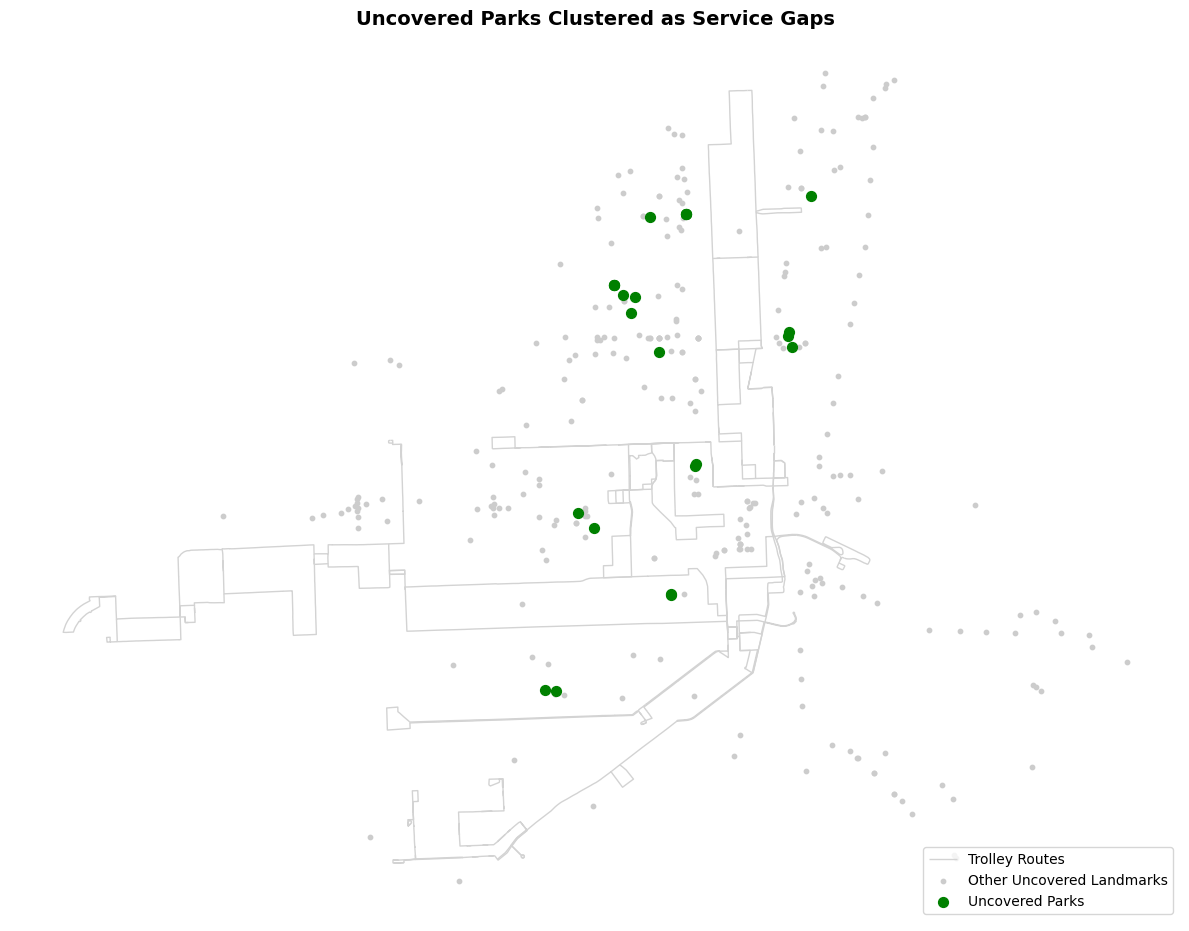

In [ ]:
# Filter uncovered landmarks labeled as Park and clustered
park_landmarks = uncovered[
    (uncovered["cluster"] != -1) & (uncovered["LMCNAME"] == "Park")
]

# Plot all uncovered landmarks with highlighted Park category
fig, ax = plt.subplots(figsize=(12, 12))

# Plot trolley routes
trolley.plot(ax=ax, color="lightgray", linewidth=1, label="Trolley Routes")

# Plot all uncovered landmarks in gray
uncovered.plot(ax=ax, color="#cccccc", markersize=10, label="Other Uncovered Landmarks")

# Highlight uncovered parks
park_landmarks.plot(ax=ax, color="green", markersize=50, label="Uncovered Parks")

plt.title("Uncovered Parks Clustered as Service Gaps", fontsize=14, fontweight="bold")
plt.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.show()


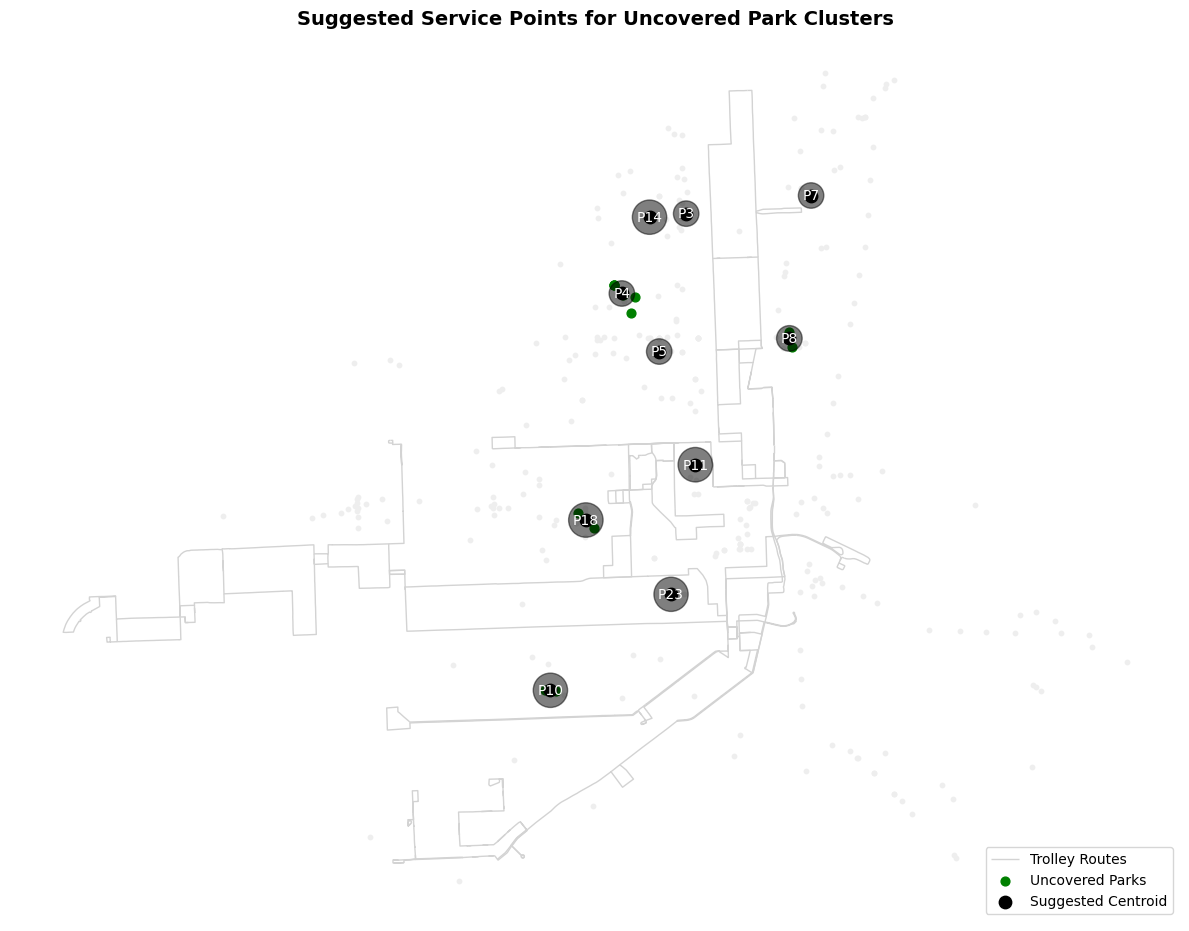

In [ ]:
from shapely.geometry import Point
import numpy as np

# Compute cluster centroids by averaging coordinates
park_centroids = (
    park_landmarks.groupby("cluster")["geometry"]
    .apply(lambda g: Point(np.mean([p.x for p in g]), np.mean([p.y for p in g])))
    .reset_index(name="geometry")
)
park_centroids_gdf = gpd.GeoDataFrame(park_centroids, geometry="geometry", crs=uncovered.crs)

# Plot clusters with centroids
fig, ax = plt.subplots(figsize=(12, 12))

trolley.plot(ax=ax, color="lightgray", linewidth=1, label="Trolley Routes")
uncovered.plot(ax=ax, color="#eeeeee", markersize=10)
park_landmarks.plot(ax=ax, color="green", markersize=40, label="Uncovered Parks")

# Plot centroids and label them
park_centroids_gdf.plot(ax=ax, color="black", markersize=80, label="Suggested Centroid")
for idx, row in park_centroids_gdf.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y, f"P{row['cluster']}",
        fontsize=10, ha="center", va="center", color="white",
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='circle')
    )

plt.title("Suggested Service Points for Uncovered Park Clusters", fontsize=14, fontweight="bold")
plt.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# Get full names of parks by cluster
park_names_by_cluster = (
    park_landmarks.groupby("cluster")["LMNAME"]
    .apply(lambda names: ", ".join(names.unique()))
    .reset_index(name="Park Names")
)

# Merge with original park_summary
park_summary = focused_summary[focused_summary["LMCNAME"] == "Park"].copy()
park_summary = park_summary.merge(park_names_by_cluster, left_on="cluster", right_on="cluster", how="left")

# Rename columns for clarity
park_summary.columns = ["Cluster", "Category", "Landmark Count", "Avg Distance to Trolley", "Park Names"]
park_summary = park_summary.sort_values("Cluster").reset_index(drop=True)

# Display result
park_summary


,Cluster,Category,Landmark Count,Avg Distance to Trolley,Park Names
0,3,Park,3,500.217410,"EDISON CENTER PARK, EDISON CENTER POOL, ATHALI..."
1,4,Park,6,1850.422165,"CHARLES HADLEY PK, WEST BUENA VISTA PK, HADLEY..."
2,5,Park,1,1143.865549,MOORE PARK
3,7,Park,1,321.444205,LEGION PK
4,8,Park,3,561.039540,"PALLOT PARK, ALBERT PALLOT PK, ELIZABETH MARTE..."
5,10,Park,2,543.272508,"SHENANDOAH PARK, SHENANDOAH POOL"
6,11,Park,2,345.550295,"TOWN PK, WILLIAMS PARK"
7,14,Park,1,1237.090941,TACOLCY PK CENTER
8,18,Park,2,526.077274,"SEWELL PK, GROVE PK"
9,23,Park,2,380.610440,"RIVERSIDE PARK, RIVERSIDE PK"


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import numpy as np

# Load data
landmarks = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Landmarks.geojson")
trolley = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Trolley_Routes.geojson")
neighborhoods = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Neighborhoods_Shapefile.geojson")

# Ensure consistent CRS (project to EPSG:3857)
landmarks = landmarks.to_crs(epsg=3857)
trolley = trolley.to_crs(landmarks.crs)
neighborhoods = neighborhoods.to_crs(landmarks.crs)

# Create trolley buffer
trolley_buffer = trolley.copy()
trolley_buffer["geometry"] = trolley_buffer.buffer(300)

# Identify uncovered landmarks
landmarks = landmarks.reset_index(drop=True)
landmarks_covered = gpd.sjoin(landmarks, trolley_buffer, how="inner", predicate="intersects")
landmarks["covered"] = landmarks.index.isin(landmarks_covered.index)
uncovered = landmarks[landmarks["covered"] == False].copy()

# Compute minimum distance to trolley
trolley_lines = list(trolley.geometry)
uncovered["min_dist_to_trolley"] = uncovered.geometry.apply(lambda pt: min(pt.distance(line) for line in trolley_lines))

# Perform DBSCAN clustering
coords = np.array(list(zip(uncovered.geometry.x, uncovered.geometry.y)))
db = DBSCAN(eps=300, min_samples=3).fit(coords)
uncovered["cluster"] = db.labels_

# Spatial join with neighborhoods
uncovered_with_neigh = gpd.sjoin(uncovered, neighborhoods, how="left", predicate="intersects")

# Identify neighborhood name column
neigh_col = [col for col in neighborhoods.columns if col.lower() in ["name", "neighborhood", "label"]]
neigh_col = neigh_col[0] if neigh_col else neighborhoods.columns[-1]

# Aggregate and summarize
neigh_cluster_summary = uncovered_with_neigh[uncovered_with_neigh["cluster"] != -1].groupby(
    ["cluster", neigh_col]
).agg(
    landmark_count=("LMNAME", "count"),
    avg_distance=("min_dist_to_trolley", "mean")
).reset_index().sort_values(["landmark_count", "avg_distance"], ascending=[False, True])

# Display summary
neigh_cluster_summary.head(20)


,cluster,LABEL,landmark_count,avg_distance
13,6,Government Center,11,379.948973
14,6,Parkwest,10,368.046774
12,5,Santa Clara,10,1160.743515
5,3,Edison,9,527.325439
9,4,Hadley Park,9,1840.583507
31,19,West Grapeland Heights,6,657.743742
1,0,Santa Clara,6,1945.332765
21,10,Shenandoah South,5,491.098553
28,18,North Sewell Park,5,537.774415
30,19,Le Jeune Gardens,5,776.758422


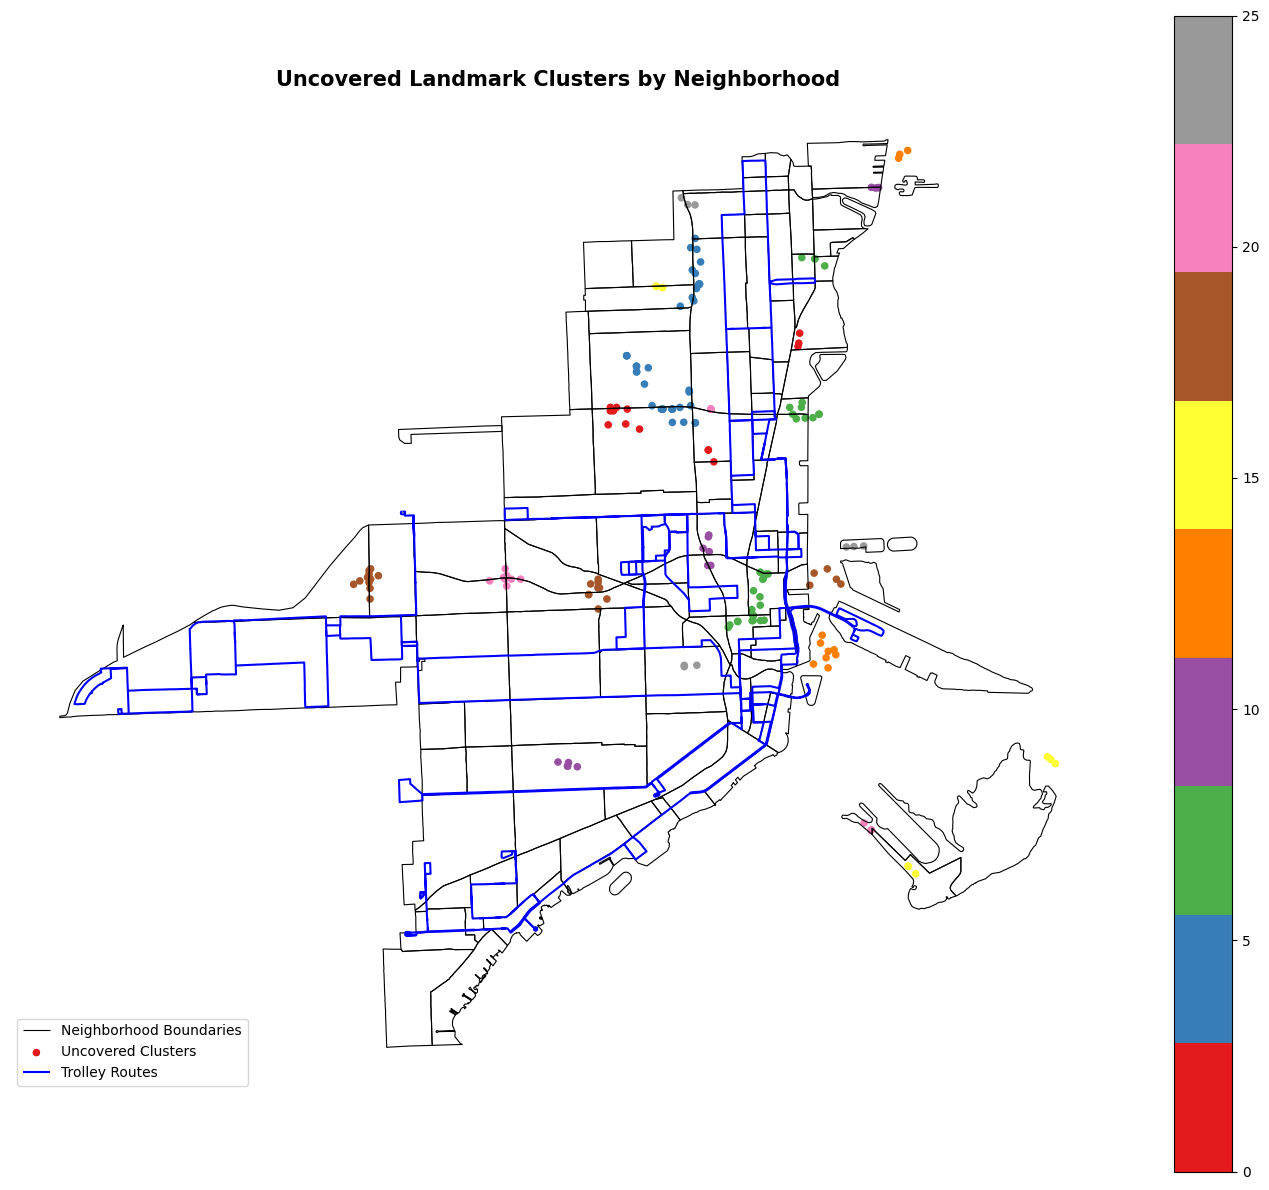

In [ ]:
import matplotlib.pyplot as plt

# Plot clusters of uncovered landmarks over neighborhoods and trolley routes
fig, ax = plt.subplots(figsize=(14, 12))

# Plot neighborhood boundaries
neighborhoods.boundary.plot(ax=ax, color="black", linewidth=0.8, label="Neighborhood Boundaries")

# Plot clustered uncovered landmarks
uncovered[uncovered["cluster"] != -1].plot(
    ax=ax,
    column="cluster",
    cmap="Set1",
    legend=True,
    markersize=20,
    label="Uncovered Clusters"
)

# Plot trolley routes
trolley.plot(ax=ax, color="blue", linewidth=1.5, label="Trolley Routes")

# Final formatting
plt.title("Uncovered Landmark Clusters by Neighborhood", fontsize=15, fontweight="bold")
plt.axis("off")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
